In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import torchaudio
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
cudnn.benchmark = True
plt.ion()   # interactive mode

# Spektogram Creator
Here we create two spektrogram datasets, with different encodings

In [2]:
#Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised)
emotionMap = {1: 'neutral', 2: 'calm', 3: 'happy',4: 'sad', 5: 'angry', 6: 'fearful', 7: 'disgust', 8: 'surprised'}

In [3]:
def load_audio_files(path: str):

    dataset = []
    walker = sorted(str(p) for p in Path(path).glob(f'*.wav'))

    for i, file_path in enumerate(walker):
        path, filename = os.path.split(file_path)
        
        label = str(emotionMap[int(filename[7:8])])
        # Load audio
        waveform, sample_rate = torchaudio.load(file_path)
        dataset.append([waveform, sample_rate, label])
        
    return dataset

In [4]:
def create_spectrogram_images(dataloader, phase):
    #make directory
    directory = f'./data/spectrograms/{phase}/'
    if not os.path.isdir(directory):
        os.makedirs(directory, exist_ok=True)
        
    for i, data in enumerate(dataloader):
        waveform = data[0]
        sample_rate = data[1][0]
        label = data[2][0]
        # create transformed waveforms
        spectrogram_tensor = torchaudio.transforms.MelSpectrogram(n_mels= 128, sample_rate=sample_rate,n_fft=2048)(waveform)     
        for map_ in ['jet','viridis']:
            fig = plt.figure(figsize=(10,10))
            plt.gca().set_axis_off()
            plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
            directory = f'./data/{map_}/spectrograms/{phase}/{label}/'
            if not os.path.isdir(directory):
                os.makedirs(directory, mode=0o777, exist_ok=True)
            plt.figure()
            plt.subplot(111)
            plt.axis('off')
            plt.box(False)
            fig1 = plt.gcf()
            plt.imshow(spectrogram_tensor[0].log2()[0,:,:].numpy(), cmap=map_)
            plt.draw()
            plt.box(False)
            fig1.savefig(f'./data/{map_}/spectrograms/{phase}/{label}/spec_img{i}.jpg', pad_inches = 0, bbox_inches='tight')
            plt.close('all')

In [5]:
# for phase in ['test','train']:
#     print(f'Now preparing {phase} data')
#     speechcommands = load_audio_files(f'../input/speechdataraw/{phase}/{phase}')
#     dataloader = torch.utils.data.DataLoader(speechcommands, batch_size=1,
#                                                 shuffle=False, num_workers=0)
#     create_spectrogram_images(dataloader, phase)

# Librosa Audio Processing

In [6]:
import numpy as np
import librosa
from PIL import Image
def get_melspectrogram_db(file_path, sr=None, n_fft=2048, hop_length=512, n_mels=128, fmin=20, fmax=8300, top_db=80):
    wav,sr = librosa.load(file_path,sr=sr)
    if wav.shape[0]<5*sr:
        wav=np.pad(wav,int(np.ceil((5*sr-wav.shape[0])/2)),mode='reflect')
    else:
        wav=wav[:5*sr]
    spec=librosa.feature.melspectrogram(wav, sr=sr, n_fft=n_fft,
              hop_length=hop_length,n_mels=n_mels,fmin=fmin,fmax=fmax)
    spec_db=librosa.power_to_db(spec,top_db=top_db)
    return spec_db



def spec_to_image(spec, eps=1e-6):
    mean = spec.mean()
    std = spec.std()
    spec_norm = (spec - mean) / (std + eps)
    spec_min, spec_max = spec_norm.min(), spec_norm.max()
    spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
    spec_scaled = spec_scaled.astype(np.uint8)
    return spec_scaled


def load_audio_files_librosa(path: str, phase: str):

    dataset = []
    walker = sorted(str(p) for p in Path(path).glob(f'*.wav'))
    
    directory = f'./data/librosa/{phase}/'
    if not os.path.isdir(directory):
        os.makedirs(directory, exist_ok=True) 
    
    for i, file_path in enumerate(walker):
        path, filename = os.path.split(file_path)  
        label = str(emotionMap[int(filename[7:8])])
        spec = get_melspectrogram_db(file_path)
        spec_scaled = spec_to_image(spec)
        directory = f'./data/librosa/{phase}/{label}'
        if not os.path.isdir(directory):
            os.makedirs(directory, exist_ok=True) 
        im = Image.fromarray(spec_scaled)
        width, height = im.size   # Get dimensions

        left = (width - height)/2
        top = (height - height)/2
        right = (width + height)/2
        bottom = (height + height)/2

        # Crop the center of the image
        im = im.crop((left, top, right, bottom))
        im.save(f'./data/librosa/{phase}/{label}/{i}.jpeg')

# for phase in ['test','train']:
#     print(f'Now preparing {phase} data')
#     load_audio_files_librosa(f'../input/speechdataraw/{phase}/{phase}', phase)

# Train AlexNet with VIRIDIS encoding

In [7]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3,1,1))
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3,1,1)),
    ]),
}

data_dir = '../input/pytorchdata/data/librosa'
image_datasets = {x: torchvision.datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    train_acc = []
    test_acc = []
    train_loss = []
    test_loss = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                train_acc.append(epoch_acc.cpu())
                train_loss.append(epoch_loss)
            else:
                test_acc.append(epoch_acc.cpu())
                test_loss.append(epoch_loss)
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_acc, train_loss, test_acc, test_loss

In [9]:
epochs = 160

In [10]:
model_ft = models.alexnet(pretrained=True)
model_ft.classifier[6]=nn.Linear(4096, len(class_names), bias=True)
print(model_ft)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.00001,weight_decay=0.001)

# Decay LR by a factor of 0.1 every 30 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=100, gamma=0.1)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [11]:
model, train_acc, train_loss, test_acc, test_loss = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=epochs)
torch.save(model.state_dict(), 'emotionRecognition_alex.pt')

Epoch 0/159
----------
train Loss: 1.9951 Acc: 0.2350
test Loss: 1.8507 Acc: 0.3125

Epoch 1/159
----------
train Loss: 1.6504 Acc: 0.4100
test Loss: 1.6635 Acc: 0.4000

Epoch 2/159
----------
train Loss: 1.3981 Acc: 0.4767
test Loss: 1.7434 Acc: 0.3708

Epoch 3/159
----------
train Loss: 1.2701 Acc: 0.5342
test Loss: 1.7117 Acc: 0.4083

Epoch 4/159
----------
train Loss: 1.1494 Acc: 0.5708
test Loss: 1.6619 Acc: 0.4125

Epoch 5/159
----------
train Loss: 1.0593 Acc: 0.5958
test Loss: 1.7438 Acc: 0.4000

Epoch 6/159
----------
train Loss: 0.9686 Acc: 0.6492
test Loss: 1.6808 Acc: 0.4083

Epoch 7/159
----------
train Loss: 0.8921 Acc: 0.6600
test Loss: 1.7477 Acc: 0.4333

Epoch 8/159
----------
train Loss: 0.8207 Acc: 0.7083
test Loss: 1.8181 Acc: 0.4417

Epoch 9/159
----------
train Loss: 0.7409 Acc: 0.7342
test Loss: 1.7676 Acc: 0.4625

Epoch 10/159
----------
train Loss: 0.6698 Acc: 0.7675
test Loss: 1.8111 Acc: 0.4458

Epoch 11/159
----------
train Loss: 0.6282 Acc: 0.7808
test Loss

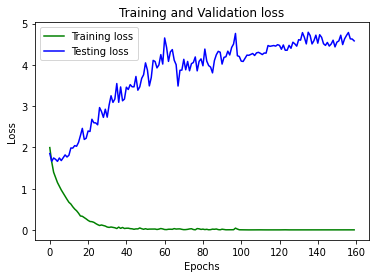

In [12]:
epochsLst = range(0,epochs)
plt.plot(epochsLst, train_loss, 'g', label='Training loss')
plt.plot(epochsLst, test_loss, 'b', label='Testing loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss_alex.png')
plt.show()

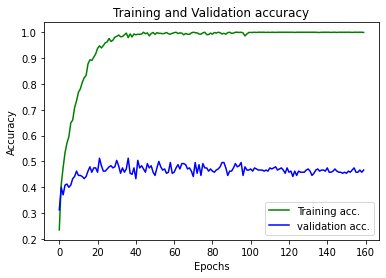

In [13]:
epochsLst = range(0,epochs)
plt.plot(epochsLst, train_acc, 'g', label='Training acc.')
plt.plot(epochsLst, test_acc, 'b', label='validation acc.')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('accuracy_alex.png')
plt.show()

# Train ResNet18 WITH JET encoding

In [14]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3,1,1))
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3,1,1))
    ]),
}

data_dir = '../input/pytorchdata/data/librosa'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [15]:
model_ft = torchvision.models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

print(model_ft)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001,weight_decay=0.001)

# Decay LR by a factor of 0.1 every 30 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=100, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
model, train_acc, train_loss, test_acc, test_loss = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=epochs)
torch.save(model.state_dict(), 'emotionRecognition_restnet.pt')

Epoch 0/159
----------
train Loss: 1.5108 Acc: 0.4225
test Loss: 1.5347 Acc: 0.4792

Epoch 1/159
----------
train Loss: 0.6549 Acc: 0.7900
test Loss: 1.5709 Acc: 0.5000

Epoch 2/159
----------
train Loss: 0.2533 Acc: 0.9342
test Loss: 1.7872 Acc: 0.4417

Epoch 3/159
----------
train Loss: 0.1230 Acc: 0.9808
test Loss: 1.6930 Acc: 0.4875

Epoch 4/159
----------
train Loss: 0.0644 Acc: 0.9950
test Loss: 1.8947 Acc: 0.4708

Epoch 5/159
----------
train Loss: 0.0571 Acc: 0.9950
test Loss: 1.7533 Acc: 0.4792

Epoch 6/159
----------
train Loss: 0.0811 Acc: 0.9817
test Loss: 1.8588 Acc: 0.4625

Epoch 7/159
----------
train Loss: 0.1055 Acc: 0.9750
test Loss: 1.8975 Acc: 0.5042

Epoch 8/159
----------
train Loss: 0.1007 Acc: 0.9708
test Loss: 2.0364 Acc: 0.4875

Epoch 9/159
----------
train Loss: 0.1278 Acc: 0.9617
test Loss: 2.0094 Acc: 0.4500

Epoch 10/159
----------
train Loss: 0.0879 Acc: 0.9817
test Loss: 1.6902 Acc: 0.5000

Epoch 11/159
----------
train Loss: 0.0918 Acc: 0.9733
test Loss

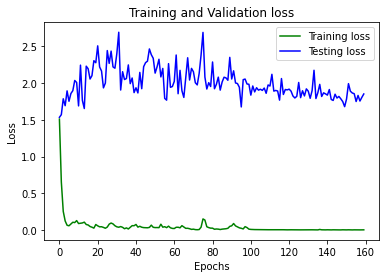

In [17]:
epochsLst = range(0,epochs)
plt.plot(epochsLst, train_loss, 'g', label='Training loss')
plt.plot(epochsLst, test_loss, 'b', label='Testing loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss_resnet.png')
plt.show()

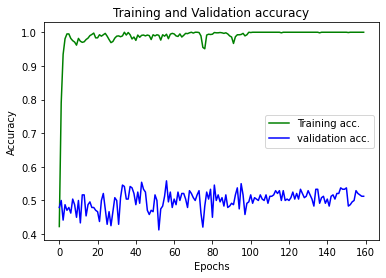

In [18]:
epochsLst = range(0,epochs)
plt.plot(epochsLst, train_acc, 'g', label='Training acc.')
plt.plot(epochsLst, test_acc, 'b', label='validation acc.')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('accuracy_resnet.png')
plt.show()